Using cpu device
-----------------------------
| time/              |      |
|    fps             | 924  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 781         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008012377 |
|    clip_fraction        | 0.0409      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.0981      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00635    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00471    |
|    value_loss           | 0.0571      |
-----------------------------------------
-----------------

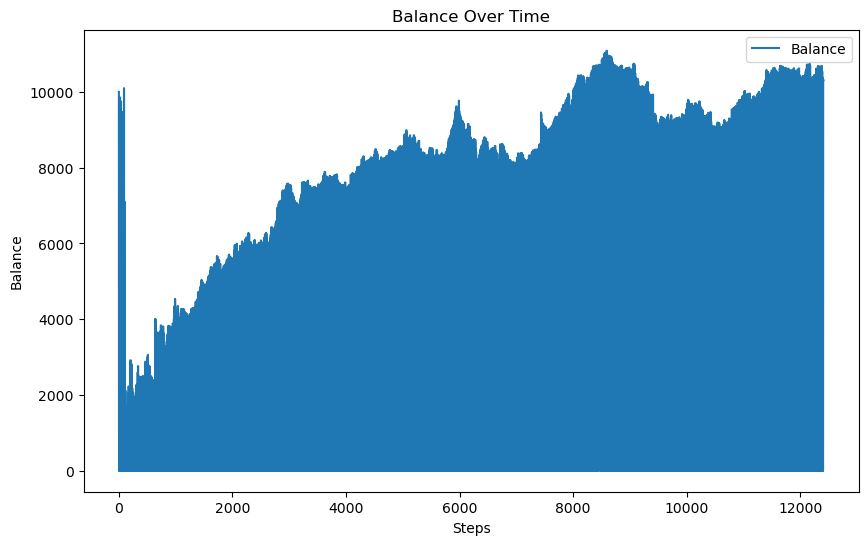

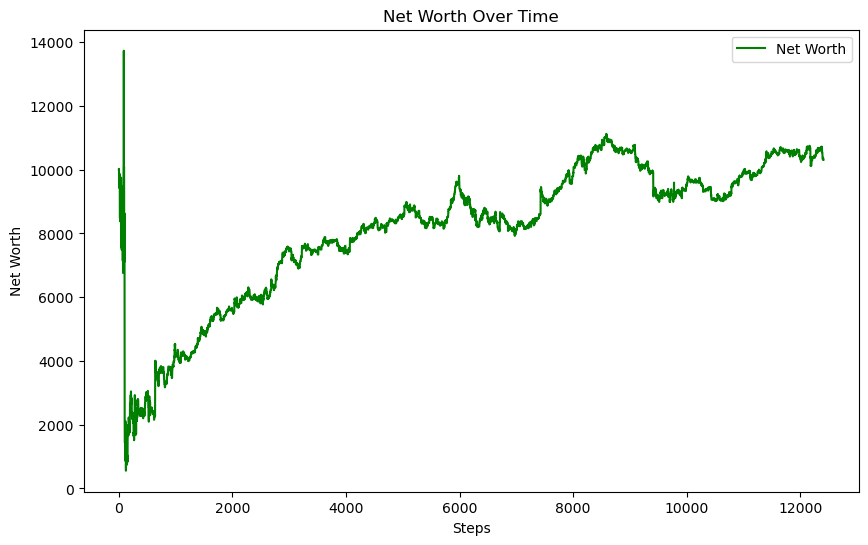

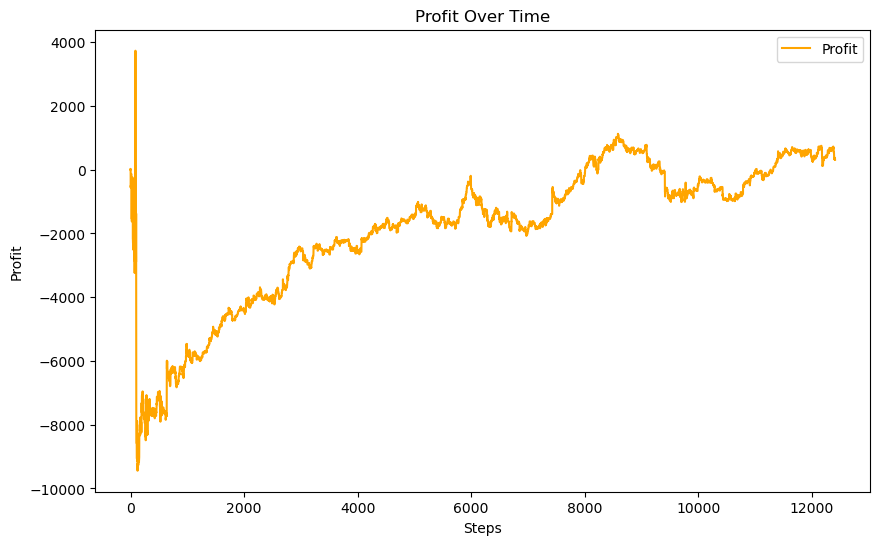

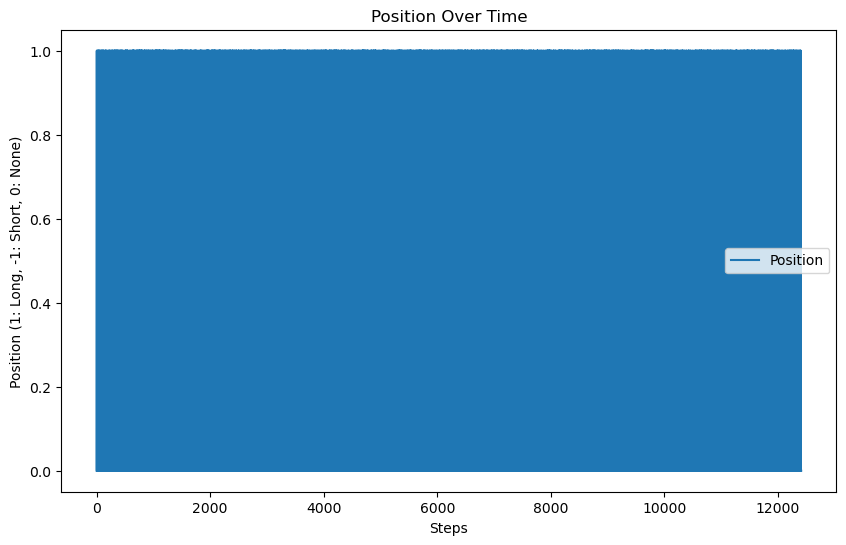

In [2]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# =================================
# 2. LOADING AND PREPROCESSING DATA
# =================================
# Load data
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\Trading Bot\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================
# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================
# Forward fill to handle NaNs
df = df.ffill()
# Drop remaining NaN rows
df = df.dropna().reset_index(drop=True)

# =====================================
# 5. COMBINING ALL FEATURES AND SCALING
# =====================================
# Combine all features (price, volume, and technical indicators) for scaling
features_to_scale = ['Open', 'High', 'Low', 'Close', 'TickVol', 'Spread']
features_to_scale_ti = [
    'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
    'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 'ATR',
    'OBV', 'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
]
all_features_to_scale = features_to_scale + features_to_scale_ti

# Scale all combined features at once
scaler = MinMaxScaler()
df[all_features_to_scale] = scaler.fit_transform(df[all_features_to_scale])

# Save the scaler for future use (e.g., during inference or further training)
joblib.dump(scaler, 'scaler.pkl')

# =========================================
# 6. DEFINING FOREX TRADING RL ENVIRONMENT
# =========================================
class ForexTradingEnv(gym.Env):
    """
    A custom OpenAI Gym environment for Forex trading using reinforcement learning.
    """
    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)  # Ensure the DataFrame index is sequential
        self.total_steps = len(self.df)

        # Initial account balance
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.position = 0  # 0: no position, 1: long
        self.position_size = 0

        # For tracking history
        self.balance_history = []
        self.net_worth_history = []
        self.profit_history = []
        self.position_history = []

        # Select only numerical columns for observation
        self.numeric_columns = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell

        # Observation space: all numerical features
        num_features = len(self.numeric_columns)
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_features,), dtype=np.float32)

    def reset(self, seed=None):
        """
        Reset the state of the environment to an initial state.
        """
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.position = 0
        self.position_size = 0

        # Reset history
        self.balance_history = [self.balance]
        self.net_worth_history = [self.net_worth]
        self.profit_history = [0]
        self.position_history = [self.position]

        return self._next_observation(), {}

    def _next_observation(self):
        """
        Get the observation for the current step.
        """
        # Extract the current row
        obs = self.df.loc[self.current_step, self.numeric_columns].values.astype(np.float32)

        # Replace any NaNs with zeros to ensure stability
        obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)

        return obs

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        terminated = False
        truncated = False

        # Current price
        current_price = self.df.loc[self.current_step, 'Close']

        # Execute action
        if action == 1:  # Buy
            if self.position == 0:  # Only buy if no current position
                self.position = 1
                self.position_size = self.balance / current_price
                self.balance = 0  # Use all balance for the position
        elif action == 2:  # Sell
            if self.position == 1:  # Only sell if currently long
                self.balance = self.position_size * current_price
                self.position = 0
                self.position_size = 0

        # Update net worth
        previous_net_worth = self.net_worth
        self.net_worth = self.balance + (self.position_size * current_price)

        # Calculate profit
        profit = self.net_worth - previous_net_worth

        # Prevent division by zero
        if previous_net_worth != 0:
            reward = profit / previous_net_worth  # Reward is percentage change in net worth
        else:
            reward = 0.0

        # Append history
        self.balance_history.append(self.balance)
        self.net_worth_history.append(self.net_worth)
        self.profit_history.append(self.net_worth - self.initial_balance)
        self.position_history.append(self.position)

        # Move to the next step
        self.current_step += 1

        # Check termination conditions
        if self.current_step >= self.total_steps - 1:
            terminated = True
            truncated = True  # Episode truncated at the end of data

        if self.net_worth <= 0:
            terminated = True
            truncated = False  # Episode terminated due to bankruptcy

        # Ensure no NaNs in reward
        if np.isnan(reward):
            reward = -1.0  # Assign a large negative reward for invalid states

        # Get the next observation
        observation = self._next_observation()

        return observation, reward, terminated, truncated, {}

    def render(self, mode='human'):
        """
        Render the environment's state.
        """
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        print(f'Net Worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')
        print(f'Position: {self.position}')
        print('-----------------------------')

# =================================
# 7. TRAINING THE RL MODEL WITH PPO
# =================================

# Create the environment and wrap it
env = ForexTradingEnv(df)
env = DummyVecEnv([lambda: env])

# Define the model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)

# Save the trained model
model.save("100000_timestamps_PPO")

# ================================
# 8. EVALUATING THE TRAINED MODEL
# ================================
# Load the trained PPO model
model = PPO.load("100000_timestamps_PPO")

# Initialize the environment
env = ForexTradingEnv(df)

# Reset the environment to start a new evaluation episode
state, info = env.reset()  # Unpack both observation and info, but use only state for model.predict()
done = False
truncated = False  # Initialize the truncated flag

while not done and not truncated:  # Evaluate until episode is done or truncated
    # Get the action from your trained model
    action, _ = model.predict(state)  # Pass only the state, not the tuple (state, info)

    # Step the environment with the chosen action
    state, reward, done, truncated, info = env.step(action)  # Unpack all five values

    # Render the current performance
    env.render()

# ========================================
# 9. PLOTTING THE RESULTS AFTER EVALUATION
# ========================================

# 1. Plot Balance Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.balance_history, label="Balance")
plt.title("Balance Over Time")
plt.xlabel("Steps")
plt.ylabel("Balance")
plt.legend()
plt.show()

# 2. Plot Net Worth Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.net_worth_history, label="Net Worth", color='green')
plt.title("Net Worth Over Time")
plt.xlabel("Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.show()

# 3. Plot Profit Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.profit_history, label="Profit", color='orange')
plt.title("Profit Over Time")
plt.xlabel("Steps")
plt.ylabel("Profit")
plt.legend()
plt.show()

# 4. Plot Position Over Time (Long/Short/None)
plt.figure(figsize=(10, 6))
plt.plot(env.position_history, label="Position")
plt.title("Position Over Time")
plt.xlabel("Steps")
plt.ylabel("Position (1: Long, -1: Short, 0: None)")
plt.legend()
plt.show()